## mk3 and street fighter with stable baselines

## can train on all models that support multibinary actions (PPO2, A2C)

Models need finetuning, they don't perfom well with the base parameters

Github: [https://github.com/hill-a/stable-baselines](https://github.com/hill-a/stable-baselines)

Really good documentation: [https://stable-baselines.readthedocs.io/](https://stable-baselines.readthedocs.io/)


## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [1]:
!pip install stable-baselines[mpi]==2.8.0
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x

     |████████████████████████████████| 225kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [2]:
!pip install gym-retro atari_py

     |████████████████████████████████| 162.0MB 94kB/s 


## Import policy, RL agent, ROM

Import roms

In [3]:
!pwd

/content


In [4]:
!python -m retro.import .

Importing 20 potential games...
Importing MortalKombat3-Genesis
Importing StreetFighterIISpecialChampionEdition-Genesis
Imported 2 games


In [5]:
import gym
import retro
import numpy as np

from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2,A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Helper function to evaluate the agent

In [0]:
def evaluate(model, num_steps=1000):
  """
  Evaluate a RL agent
  :param model: (BaseRLModel object) the RL Agent
  :param num_steps: (int) number of timesteps to evaluate it
  :return: (float) Mean reward for the last 100 episodes
  """
  episode_rewards = [0.0]
  obs = env.reset()
  for i in range(num_steps):
      # _states are only useful when using LSTM policies
      action, _states = model.predict(obs)
      # here, action, rewards and dones are arrays
      # because we are using vectorized env
      obs, rewards, dones, info = env.step(action)
      
      # Stats
      episode_rewards[-1] += rewards[0]
      if dones[0]:
          obs = env.reset()
          episode_rewards.append(0.0)
  # Compute mean reward for the last 100 episodes
  mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
  print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
  
  return mean_100ep_reward

## Define a Callback Function

In [0]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    # Returning False will stop training early
    return True

## Create log directory to store eval metrics and make env

In [0]:
import os
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.results_plotter import load_results, ts2xy

log_dir = "/tmp/gym/"

def create_env(env_id):
  os.makedirs(log_dir, exist_ok=True)

  # Create and wrap the environment
  env = retro.make(game=env_id)

  # Logs will be saved in log_dir/monitor.csv
  env = Monitor(env, log_dir, allow_early_resets=True)

  # Because we use parameter noise, we should use a MlpPolicy with layer normalization
  return DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run

In [0]:
env = create_env('MortalKombat3-Genesis')

In [0]:
# Choose model
model = PPO2(MlpPolicy, env, verbose=0)
# model = A2C(CnnPolicy, env, verbose=0)

# Random Agent evaluation, before training
mean_reward_before_train = evaluate(model, num_steps=10000)

# Train the agent
model.learn(total_timesteps=int(50000), callback=callback)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Mean reward: 146.2 Num episodes: 4


## Evaluation and plots

In [0]:
# Evaluate agent after training
mean_reward_after_train = evaluate(model, num_steps=10000)

Mean reward: 436.5 Num episodes: 2


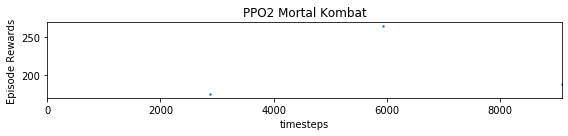

In [0]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 10000, results_plotter.X_TIMESTEPS, "PPO2 Mortal Kombat")

## Save and load the model

In [0]:
# Save the agent
os.mkdir('models')
model.save("models/ppo2_mk3")
del model  # delete trained model to demonstrate loading

In [0]:
model = PPO2.load("models/ppo2_mk3")





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







## Store game play by trained model in mp4

not working for trained model yet, works for random moves

In [0]:
import gym
from stable_baselines.common.vec_env import VecVideoRecorder

env_id = 'MortalKombat3-Genesis'
video_folder = 'logs/videos/'
video_length = 100000

env = create_env('MortalKombat3-Genesis')

obs = env.reset()

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix="random-agent-{}".format(env_id))

env.reset()

array([[[[64, 68, 64],
         [64, 68, 64],
         [64, 68, 64],
         ...,
         [64, 68, 64],
         [64, 68, 64],
         [64, 68, 64]],

        [[64, 68, 64],
         [64, 32, 32],
         [64, 68, 64],
         ...,
         [64, 68, 64],
         [64, 32, 32],
         [64, 68, 64]],

        [[64, 68, 64],
         [64, 68, 64],
         [64, 68, 64],
         ...,
         [64, 68, 64],
         [64, 68, 64],
         [64, 68, 64]],

        ...,

        [[96, 32, 32],
         [96, 32, 32],
         [96, 32, 32],
         ...,
         [96, 32, 32],
         [96, 32, 32],
         [96, 32, 32]],

        [[64, 32, 32],
         [96, 32, 32],
         [96, 32, 32],
         ...,
         [96, 32, 32],
         [96, 32, 32],
         [64, 32, 32]],

        [[96, 32, 32],
         [64, 32, 32],
         [64, 32, 32],
         ...,
         [64, 32, 32],
         [64, 32, 32],
         [96, 32, 32]]]], dtype=uint8)

Store game play by the trained model in gif

In [0]:
import imageio

model.set_env(env)

images = []
obs = model.env.reset()
img = model.env.render(mode='rgb_array')
done = False
while not done:
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, done ,_ = model.env.step(action)
    img = model.env.render(mode='rgb_array')

In [0]:
imageio.mimsave('mk3_ppo2.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)